In [1]:
import torch
from torch.utils.tensorboard import SummaryWriter

from data import artificial_1D_linear as data
from utils.general import get_logging_dir
from experiments.artificial_1D_linear.documentation import (
    evaluate,
    plot_data_split,
    plot_predictions,
)
from models import SmartAverageLayer

from experiments.artificial_1D_linear.smart_fed_avg_util import (
    train_client,
    register_client_test_losses,
)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
NUM_CLIENTS = 2

COMMUNICATION_ROUNDS = 10
CLIENT_EPOCHS = 100

SPLIT_TYPE = "interval"

In [4]:
CLIENT_IDs = range(NUM_CLIENTS)

BATCH_SIZE = 64

INPUT_FEATURES = 1
OUTPUT_FEATURES = 1
ARCHITECTURE = [11, 12, 11, 12]

LOSS_FN = torch.nn.MSELoss()

In [5]:
def register_hyperparameters(writer, last_loss):
    writer.add_hparams(
        {
            "client_epochs": CLIENT_EPOCHS,
            "num_clients": NUM_CLIENTS,
            "communication_rounds": COMMUNICATION_ROUNDS,
            "split_type": SPLIT_TYPE,
            "architecture": str(ARCHITECTURE),
        },
        {
            "MSE Test": last_loss,
        },
        run_name=".",
    )

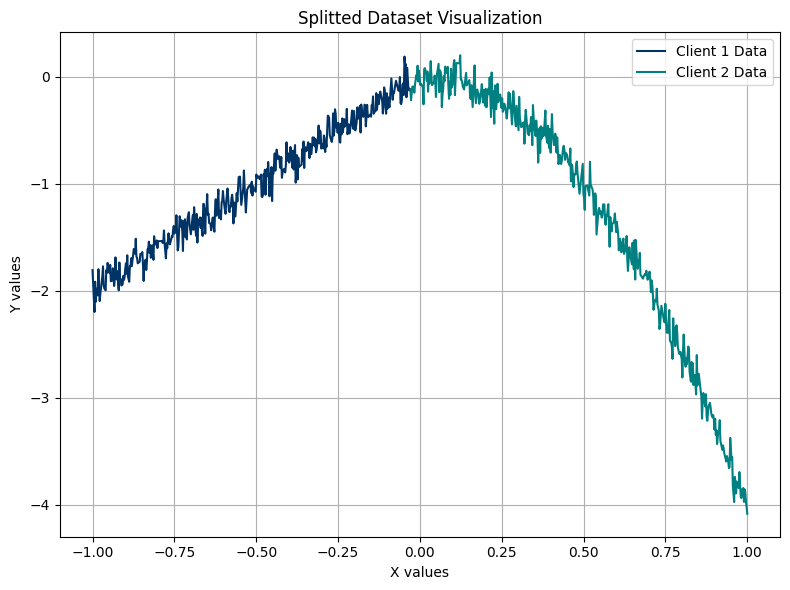

In [6]:
model_name = f"MyFed_{NUM_CLIENTS}clients_{SPLIT_TYPE}-split"
writer = SummaryWriter(get_logging_dir(model_name, "artificial_1D_linear"))

clients = [
    SmartAverageLayer.initialize_from_scratch(INPUT_FEATURES, OUTPUT_FEATURES, NUM_CLIENTS, client_id, ARCHITECTURE)
    for client_id in CLIENT_IDs
]

client_train_dataloaders = data.get_client_train_dataloaders(
    NUM_CLIENTS, SPLIT_TYPE, BATCH_SIZE, shuffle=True
)

plot_data_split(client_train_dataloaders, writer)

In [7]:
print(clients[0])

SmartAverageLayer(
  (prediction_network): MultiOutputNet(
    (hidden_layers): ModuleList(
      (0): Linear(in_features=2, out_features=11, bias=False)
      (1): Linear(in_features=12, out_features=12, bias=False)
      (2): Linear(in_features=13, out_features=11, bias=False)
      (3): Linear(in_features=12, out_features=12, bias=False)
    )
    (output_layers): ModuleList(
      (0-1): 2 x Linear(in_features=13, out_features=1, bias=False)
    )
    (output_scalings): ParameterList(
        (0): Parameter containing: [torch.float32 of size 1]
        (1): Parameter containing: [torch.float32 of size 1]
    )
  )
)


Communication Round 9/10
 global model:  SmartAverageLayer(
  (prediction_network): MultiOutputNet(
    (hidden_layers): ModuleList(
      (0): Linear(in_features=2, out_features=14, bias=False)
      (1): Linear(in_features=15, out_features=32, bias=False)
      (2): Linear(in_features=33, out_features=19, bias=False)
      (3): Linear(in_features=20, out_features=28, bias=False)
    )
    (output_layers): ModuleList(
      (0-1): 2 x Linear(in_features=29, out_features=1, bias=False)
    )
    (output_scalings): ParameterList(
        (0): Parameter containing: [torch.float32 of size 1]
        (1): Parameter containing: [torch.float32 of size 1]
    )
  )
)

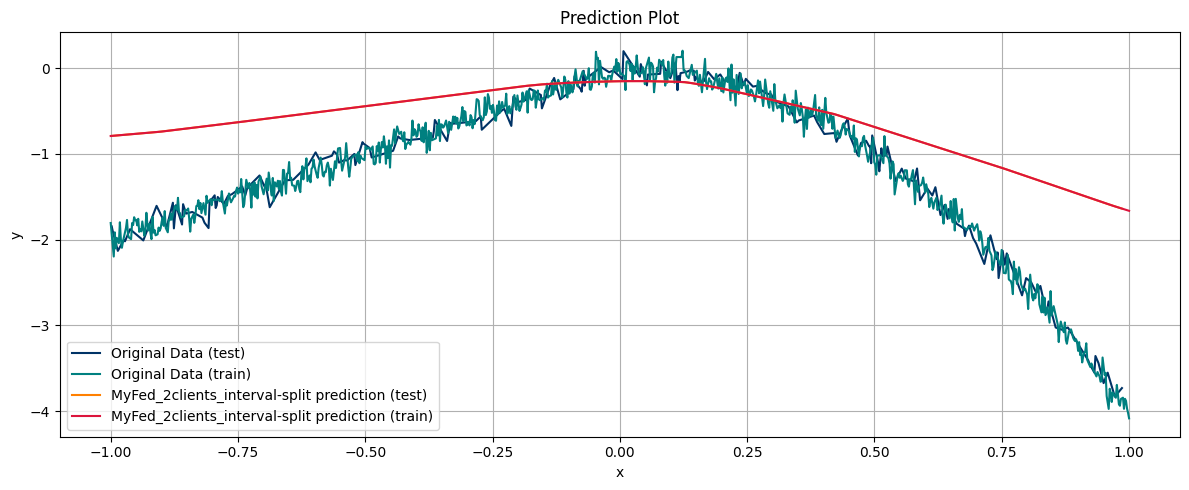

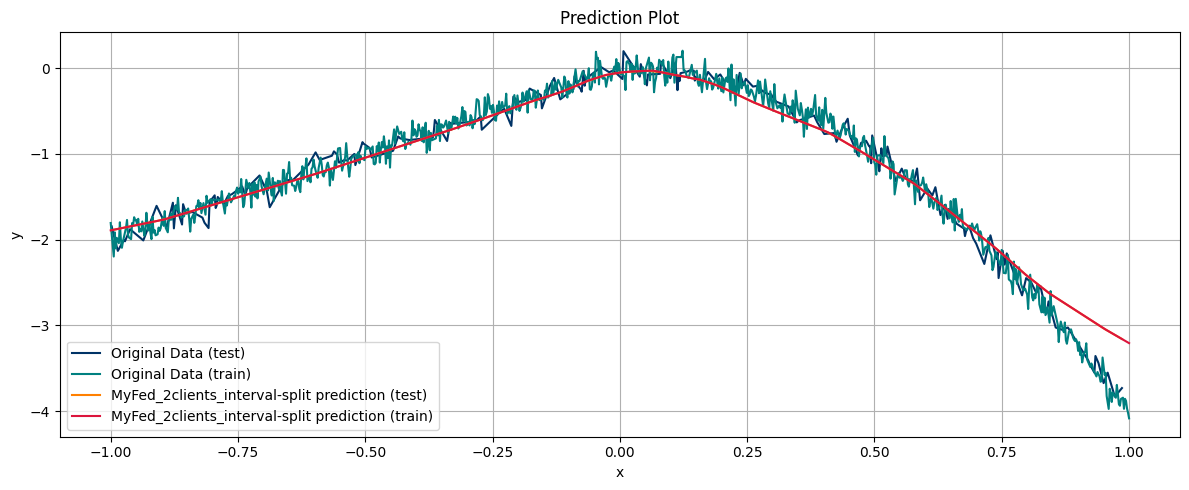

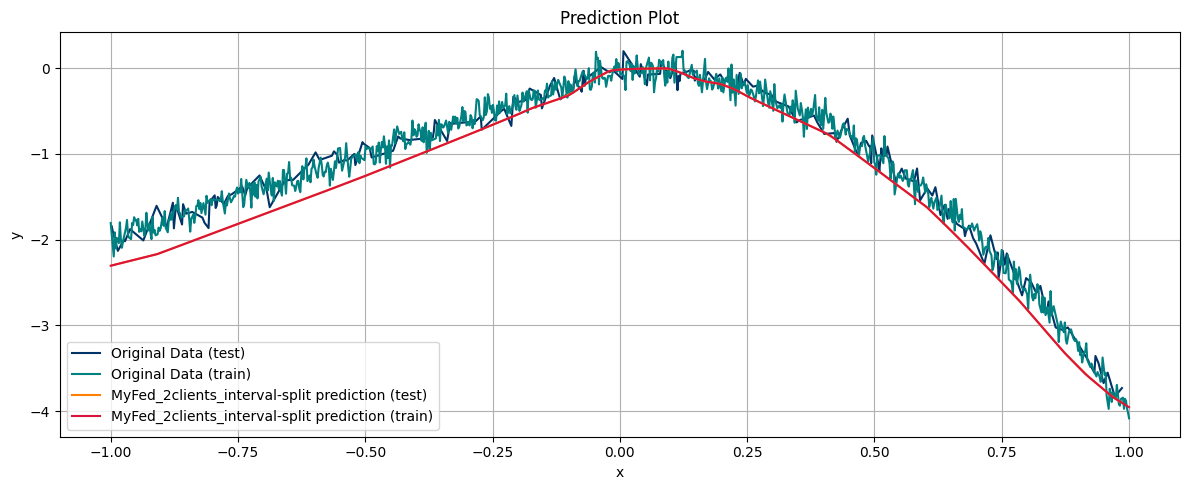

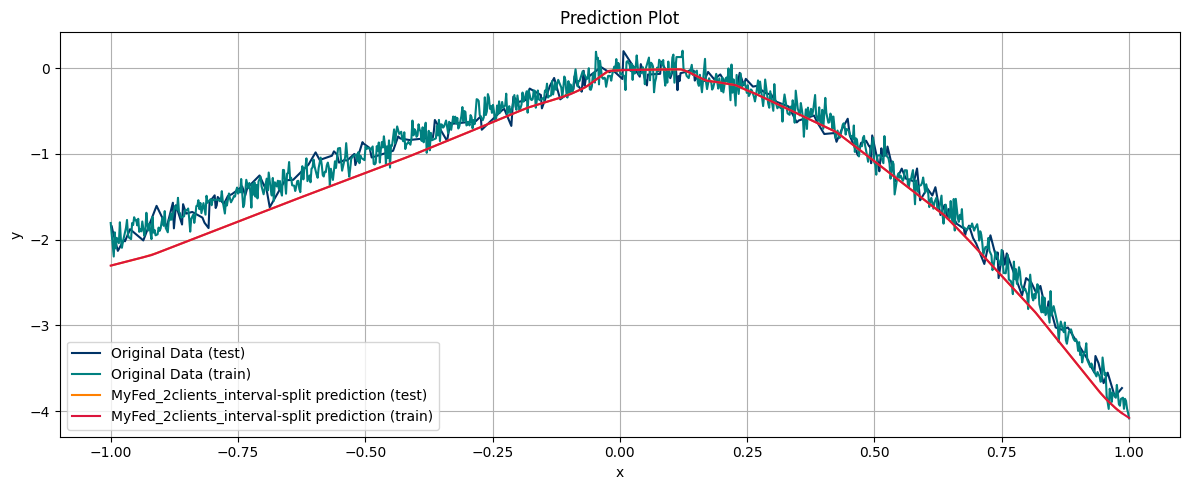

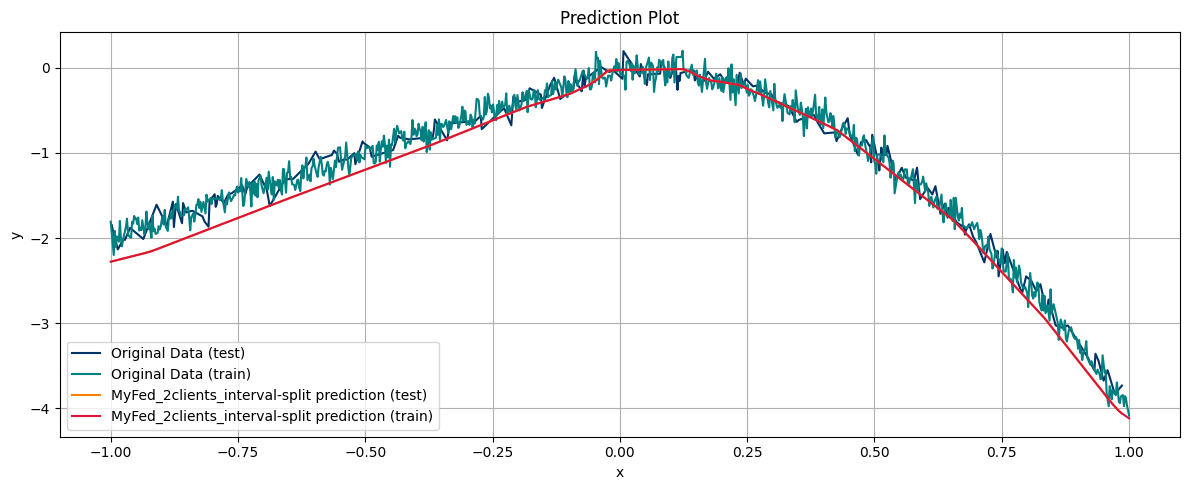

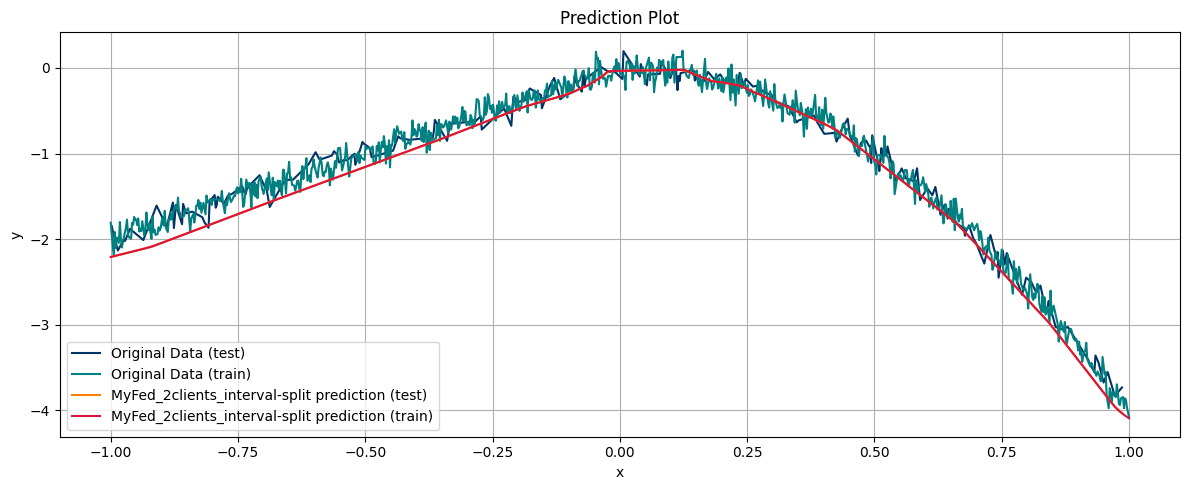

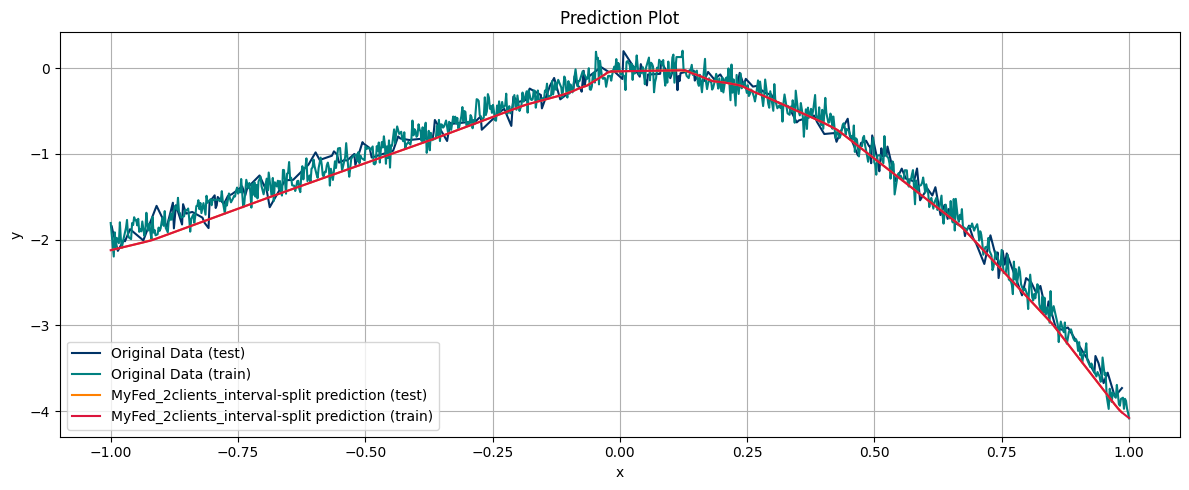

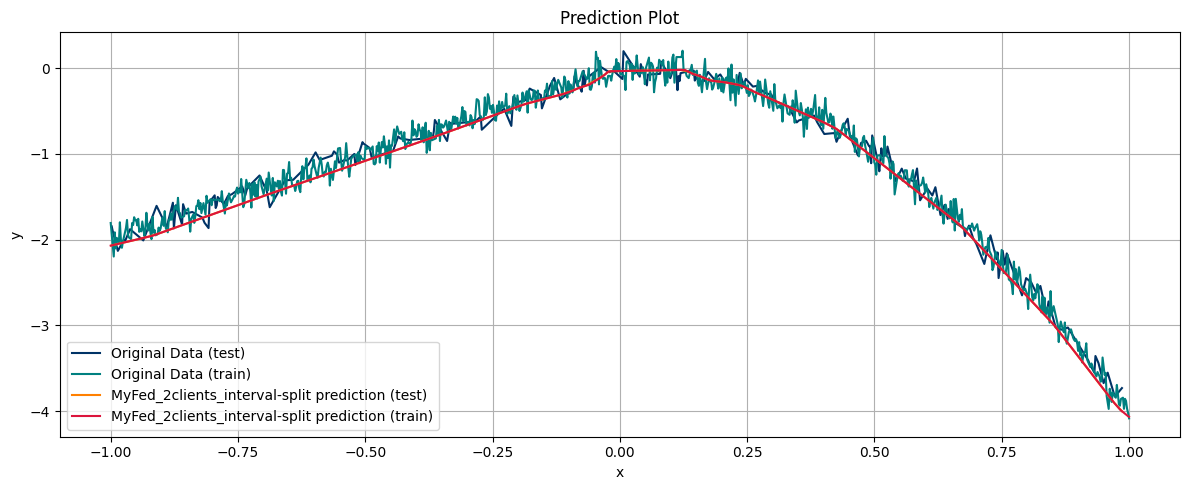

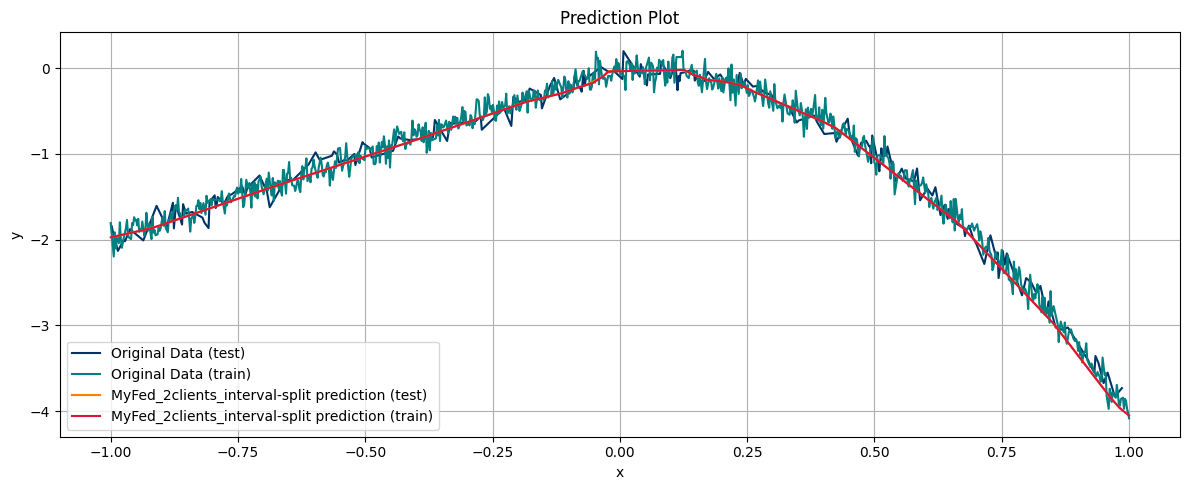

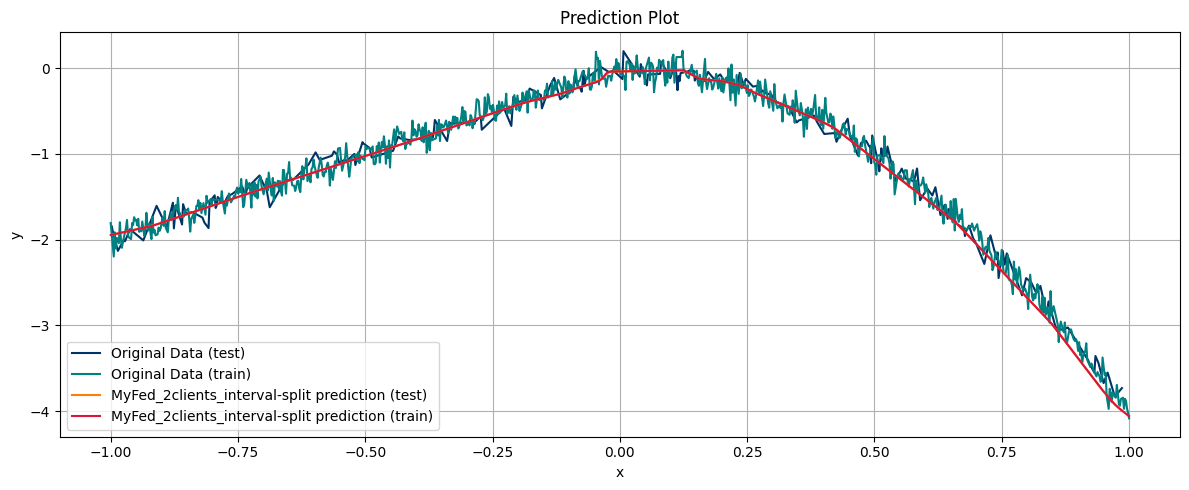

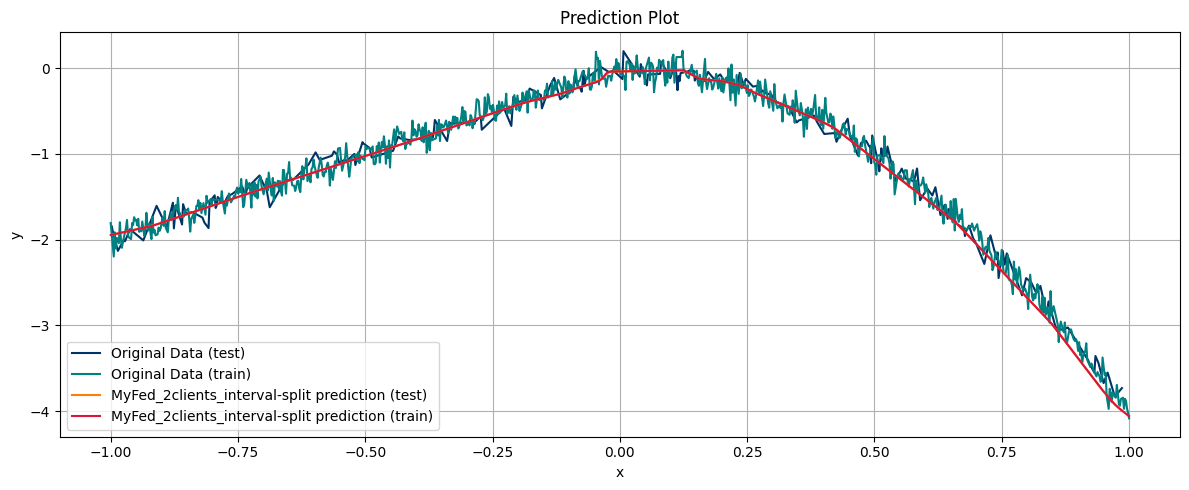

In [8]:
def is_cooling_off_epoch(cr: int):
    return cr > COMMUNICATION_ROUNDS // 2


for cr in range(COMMUNICATION_ROUNDS):
    # train each client individually
    for client_no, client in zip(CLIENT_IDs, clients):
        train_client(
            client_no=client_no,
            client_model=client,
            data_loader=client_train_dataloaders[client_no],
            loss_fn=LOSS_FN,
            no_epochs=CLIENT_EPOCHS,
            communication_round=cr,
            writer=writer,
        )

    register_client_test_losses(
        clients=clients, client_ids=CLIENT_IDs, writer=writer, communication_round=cr
    )

    global_model = SmartAverageLayer.get_global_model(
        clients,
        similarity_threshold_in_degree=30 if not is_cooling_off_epoch(cr) else 181,
    )

    writer.add_scalar("test_loss", evaluate(global_model), cr * CLIENT_EPOCHS)

    #### ----- Unimportant ----- NOTE: remove####################################################################################
    from IPython.display import clear_output

    clear_output(wait=True)
    print(f"Communication Round {cr}/{COMMUNICATION_ROUNDS}")
    print("\r global model: ", global_model, end="")
    # print("\n\n GLOBAL MODEL\n", list(global_model.named_parameters()))

    #### //// ----- Unimportant ------------------------------------------------------------------------------------------------

    clients = [
        global_model.get_client_model(
            client_id,
            add_noise=(not is_cooling_off_epoch(cr)),
        )
        for client_id in CLIENT_IDs
    ]

    plot_predictions(global_model, model_name, writer, epoch=cr)

plot_predictions(global_model, model_name, writer)
register_hyperparameters(writer, last_loss=evaluate(global_model))
writer.close()

In [9]:
print(global_model.prediction_network.full_representation())
print(global_model.prediction_mask)

SelfLearningNet Weights: (training on output None)
Layer 0 Weights:
[[ 0.69888604 -0.7152295 ]
 [ 0.7988826  -0.6014838 ]
 [-0.12139483  0.9926043 ]
 [-0.9644787  -0.26416087]
 [-0.18048114 -0.98357844]
 [ 0.9911391   0.13272342]
 [ 0.67647386  0.73646593]
 [ 0.70543784 -0.7087654 ]
 [-0.55683434  0.8306235 ]
 [-0.9580967   0.28644505]
 [ 0.9458295   0.32464594]
 [ 0.97033775 -0.24163136]
 [ 0.30655545  0.9515746 ]
 [ 0.09728754  0.9952531 ]]
Layer 1 Weights:
[[-1.47863641e-01 -5.51147938e-01 -4.16715950e-01  1.46110117e-01
   5.28722778e-02  1.48794325e-02  8.19878578e-02  9.88104939e-02
  -5.49038053e-01  9.50255990e-02  4.68251295e-02  1.25250164e-02
  -1.49873331e-01 -1.46978319e-01  3.20669562e-01]
 [-4.48721588e-01 -1.40372485e-01 -2.80647933e-01  2.62846291e-01
  -1.45401090e-01  5.34139812e-01  8.42472911e-03  4.29982662e-01
  -1.41373038e-01  1.43417209e-01 -2.40987837e-01  2.00198114e-01
  -1.21946260e-02 -2.27951389e-02  1.72788315e-02]
 [ 3.07968974e-01  1.24422600e-02  2.6

In [10]:
for client in clients:
    print(client.prediction_network.full_representation())
    print(client.prediction_mask)

SelfLearningNet Weights: (training on output 0)
Layer 0 Weights:
[[ 0.69888604 -0.7152295 ]
 [ 0.7988826  -0.6014838 ]
 [-0.12139483  0.9926043 ]
 [-0.9644787  -0.26416087]
 [-0.18048114 -0.98357844]
 [ 0.9911391   0.13272342]
 [ 0.67647386  0.73646593]
 [ 0.70543784 -0.7087654 ]
 [-0.55683434  0.8306235 ]
 [-0.9580967   0.28644505]
 [ 0.9458295   0.32464594]
 [ 0.97033775 -0.24163136]
 [ 0.30655545  0.9515746 ]
 [ 0.09728754  0.9952531 ]]
Layer 1 Weights:
[[-1.47863641e-01 -5.51147938e-01 -4.16715950e-01  1.46110117e-01
   5.28722778e-02  1.48794325e-02  8.19878578e-02  9.88104939e-02
  -5.49038053e-01  9.50255990e-02  4.68251295e-02  1.25250164e-02
  -1.49873331e-01 -1.46978319e-01  3.20669562e-01]
 [-4.48721588e-01 -1.40372485e-01 -2.80647933e-01  2.62846291e-01
  -1.45401090e-01  5.34139812e-01  8.42472911e-03  4.29982662e-01
  -1.41373038e-01  1.43417209e-01 -2.40987837e-01  2.00198114e-01
  -1.21946260e-02 -2.27951389e-02  1.72788315e-02]
 [ 3.07968974e-01  1.24422600e-02  2.6195